In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [57]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 5

START_DATE = "20240101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "interm/resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "interm/events"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}_FEATURES.pkl"

In [58]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)

CPU times: user 1.27 ms, sys: 8.42 ms, total: 9.69 ms
Wall time: 8.15 ms


In [59]:
df.shape

(73782, 60)

In [60]:
df.head()

,open,high,low,close,volume,spread,close_pct_return,close_return,close_log_return,close_fd_return,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-05 03:25:00,144.8960,144.9415,144.8940,144.9105,2.780660e+12,0.006927,0.000100,0.0145,0.000100,2.788711,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:30:00,144.9100,144.9490,144.9060,144.9470,2.220040e+12,0.006398,0.000252,0.0365,0.000252,2.810244,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:35:00,144.9465,144.9490,144.9230,144.9240,3.450710e+12,0.006930,-0.000159,-0.0230,-0.000159,2.762497,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:40:00,144.9245,144.9460,144.9155,144.9430,2.273510e+12,0.007072,0.000131,0.0190,0.000131,2.784171,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025
2024-01-05 03:45:00,144.9435,144.9510,144.9355,144.9465,1.925300e+12,0.006585,0.000024,0.0035,0.000024,2.775585,...,5,1,0.707107,0.707107,-0.433884,-0.900969,0.848644,0.528964,0.5,0.866025


In [61]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'spread', 'close_pct_return',
       'close_return', 'close_log_return', 'close_fd_return', 'EMA_5',
       'EMA_20', 'EMA_50', 'EMA_100', 'ATRr_14', 'ATRr_60', 'ATRr_120',
       'ADX_14', 'ADXR_14_2', 'DMP_14', 'DMN_14', 'RSI_14', 'RSI_25', 'RSI_50',
       'BBL_5_2.0_2.0', 'BBM_5_2.0_2.0', 'BBU_5_2.0_2.0', 'BBB_5_2.0_2.0',
       'BBP_5_2.0_2.0', 'BBL_10_2.0_2.0', 'BBM_10_2.0_2.0', 'BBU_10_2.0_2.0',
       'BBB_10_2.0_2.0', 'BBP_10_2.0_2.0', 'BBL_15_2.0_2.0', 'BBM_15_2.0_2.0',
       'BBU_15_2.0_2.0', 'BBB_15_2.0_2.0', 'BBP_15_2.0_2.0', 'BBL_20_2.0_2.0',
       'BBM_20_2.0_2.0', 'BBU_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0',
       'MACD_8_17_9', 'MACDh_8_17_9', 'MACDs_8_17_9', 'unix_time', 'hour',
       'dow', 'dom', 'month', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
       'dom_sin', 'dom_cos', 'month_sin', 'month_cos'],
      dtype='object')

## Apply Z Score Filter

In [62]:
def z_score_filter(
    closes: pd.Series,
    mean_window: int,
    std_window: int,
    z_score: float = 3,
) -> pd.DatetimeIndex:

    t_events = closes[
        closes
        >= closes.rolling(window=mean_window).mean()
        + z_score * closes.rolling(window=std_window).std()
    ].index
    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [63]:
closes = df['close']
mean_window = 100
std_window = 100
z_score = 1

In [64]:
z_score_events = z_score_filter(
    closes, 
    mean_window=mean_window, 
    std_window=std_window, 
    z_score=z_score
)

In [65]:
z_score_events

DatetimeIndex(['2024-01-05 11:40:00', '2024-01-05 11:45:00',
               '2024-01-05 11:50:00', '2024-01-05 11:55:00',
               '2024-01-05 12:00:00', '2024-01-05 13:30:00',
               '2024-01-05 13:35:00', '2024-01-05 13:40:00',
               '2024-01-05 13:45:00', '2024-01-05 13:50:00',
               ...
               '2024-12-30 08:05:00', '2024-12-30 08:10:00',
               '2024-12-30 08:55:00', '2024-12-30 09:00:00',
               '2024-12-30 09:05:00', '2024-12-30 09:10:00',
               '2024-12-30 09:15:00', '2024-12-30 09:20:00',
               '2024-12-30 09:25:00', '2024-12-30 09:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=22042, freq=None)

## Visualization

In [66]:

rolling_mean = closes.rolling(window=mean_window).mean()
rolling_std = closes.rolling(window=std_window).std()
upper_bound = rolling_mean + z_score * rolling_std
lower_bound = rolling_mean - z_score * rolling_std

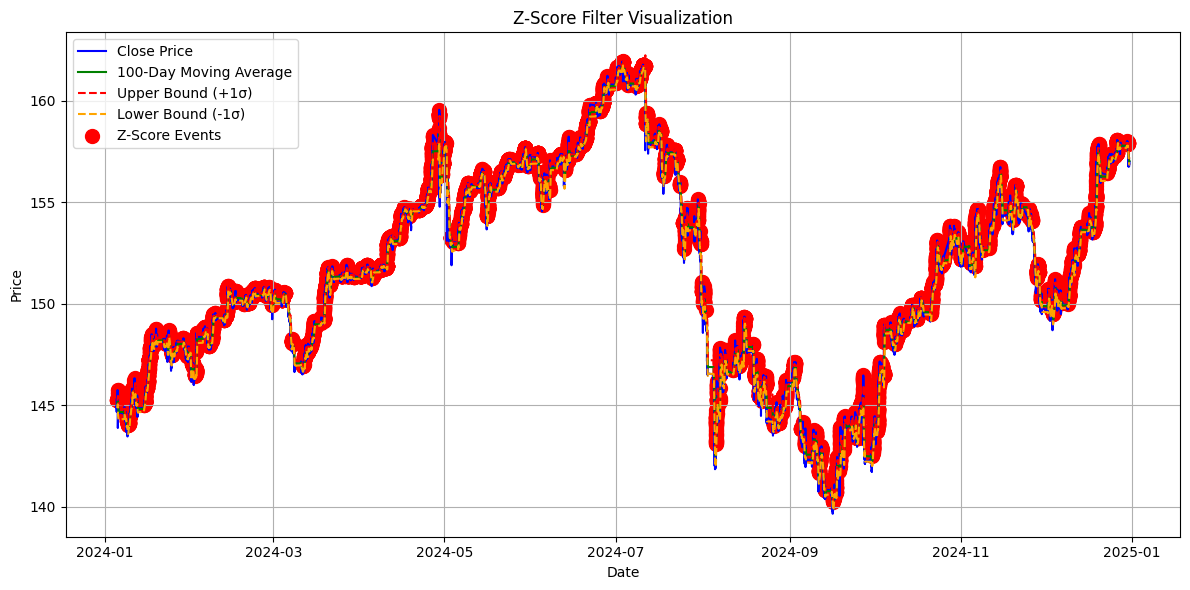

In [67]:
# 繪圖
plt.figure(figsize=(12, 6))
plt.plot(closes, label="Close Price", color="blue")
plt.plot(rolling_mean, label=f"{mean_window}-Day Moving Average", color="green")
plt.plot(upper_bound, label=f"Upper Bound (+{z_score}σ)", color="red", linestyle="--")
plt.plot(lower_bound, label=f"Lower Bound (-{z_score}σ)", color="orange", linestyle="--")
plt.scatter(
    z_score_events,
    closes[z_score_events],
    color="red",
    marker="o",
    s=100,
    label="Z-Score Events",
)
plt.title("Z-Score Filter Visualization")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save To Drive

In [68]:
EVENT_NAME = f"Z_SCORE_W{mean_window}_{z_score}Z"
EVENT_PATH = EVENTS_DIR / f"{RESAMPLED_NAME}_{EVENT_NAME}.pkl"

In [69]:
EVENT_NAME

'Z_SCORE_W100_1Z'

In [70]:
EVENT_PATH

PosixPath('../data/interm/events/USDJPY-5m-20240101-20241231_Z_SCORE_W100_1Z.pkl')

In [71]:
z_score_events.to_series().to_pickle(EVENT_PATH)